# Paper defects detection - (Manufacturing Anomaly Detection)

Paper machines move so fast that it is usually impossible for operators to detect any visual anomalies during production.   
These anomalies can range from couloured or dark spots to holes and malformations. As the types of anomalies can vary a lot in form, colour and size, and new ones could appear at any time, and as many factors could influence the visual anomaly detection, such as lighting and paper coloration, it's better to consider paper defects detection using unsupervised machine learning.  
This algorithm is meant to be implemented as following :
- The operator runs the paper machine for few minutes in a low speed, and verifies that the paper does not present anomlies.  
- The operator increases speed and starts the learning phase
- The program records 2 minutes of video as baseline
- The algorithm is trained, on the video
- The algorithm starts detection on real-time feed

This notebook shows the training and test phases using a special type a fully connected autoencoder.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import h5py

from datetime import datetime

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(0)

## Functions

We define 2 simple functions for : 
- computing the mean squared error and preprocessing images
- Flatten images and normalize the pixels to values between 0 and 1

In [2]:
def mse(x_data, x_hat_data):
    tmp=((x_data-x_hat_data)**2).mean(axis=1)
    return tmp

In [3]:
def imgprepro(x_data):
    " reshape data"
    x_temp=x_data.reshape(x_data.shape[0],x_data.shape[1] * x_data.shape[2]*x_data.shape[3])/255.
    return x_temp

## Import Data and build train and test sets

The data set is proprietary and will not be provided for this notebook.
The data provided is generated from a video captred from raspberry pi camera placed over a winding machine of a real paper manufacturing machine. The images were resized using OpenCV, to *224 x 224* RGB images.  
Two data sets were compiled, the first one contains a sequence of images where there were no defects, meant initially to be a train set. the second one contains a sequence of images were some defects appeared (ink drops). Not all images contained defects, therfore labels were created in a seperate csv file.
The first one will be used as train set and the s

Using autoencoder for anomaly detection, relies on training the algorithm on images with no anomalies, and ask the autoencoder to reproduce the input images. Therefore the train set contains only images with no defects. 

We load the the first sequence data

In [4]:
f = h5py.File('seq_1_224_c.hdf5', 'r')

seq_1_data = np.array(f['train_data'])
seq_1_data.shape

(8976, 224, 224, 3)

Here's a sample image

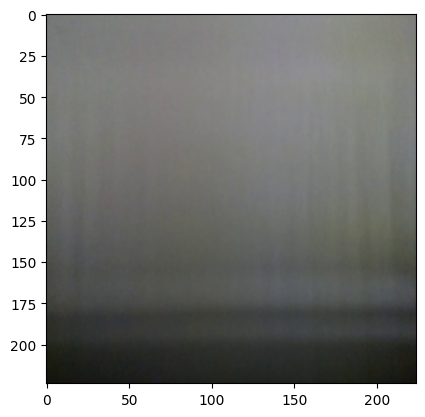

In [5]:
plt.imshow(seq_1_data[0].astype('uint8'))

### Processing the first data set

We split the first data set into train and temporary sets. We will need the temporary set to generate a validation and test sets later.

In [44]:
x_train_raw, x_tmp_raw = train_test_split(seq_1_data, test_size = 0.2, shuffle=True )

In [53]:
x_train=imgprepro(x_train_raw)
x_tmp = imgprepro(x_tmp_raw)

We Add labels to temporary set, since the second set has labels. In this case all the label will be 0 since these images present no anomalies.

In [55]:
df_tmp.shape

(1796, 150529)

In [54]:
# Turn validation sets into data frame with labels
df_tmp=pd.DataFrame(x_tmp)

df_tmp["label"] = 0
df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,150519,150520,150521,150522,150523,150524,150525,150526,150527,label
0,0.431373,0.427451,0.431373,0.450980,0.435294,0.439216,0.439216,0.435294,0.435294,0.431373,...,0.070588,0.086275,0.035294,0.074510,0.086275,0.039216,0.070588,0.086275,0.035294,0
1,0.462745,0.458824,0.443137,0.450980,0.462745,0.439216,0.462745,0.462745,0.447059,0.470588,...,0.082353,0.082353,0.070588,0.078431,0.082353,0.070588,0.082353,0.090196,0.066667,0
2,0.384314,0.392157,0.388235,0.392157,0.396078,0.392157,0.403922,0.403922,0.407843,0.388235,...,0.086275,0.086275,0.062745,0.086275,0.082353,0.062745,0.074510,0.070588,0.054902,0
3,0.384314,0.392157,0.341176,0.392157,0.392157,0.380392,0.400000,0.392157,0.388235,0.396078,...,0.070588,0.078431,0.058824,0.078431,0.078431,0.054902,0.070588,0.066667,0.047059,0
4,0.396078,0.364706,0.376471,0.403922,0.400000,0.400000,0.400000,0.396078,0.400000,0.384314,...,0.086275,0.078431,0.047059,0.090196,0.078431,0.054902,0.078431,0.070588,0.054902,0


### Processing the second data set

In [56]:
# turning the original test set into data frame (the only set that contains bad examples)
f = h5py.File('seq_2_224_c.hdf5', 'r')
seq_2_data = np.array(f['test_data'])
seq_2_temp=imgprepro(seq_2_data)
df_seq_2 = pd.DataFrame(seq_2_temp)

labels_temp=pd.read_csv("seq_2_labels.csv")
df_seq_2["label"] = labels_temp["label"]
df_seq_2.shape

(576, 150529)

We can visualize an example of an image presenting an anomaly :

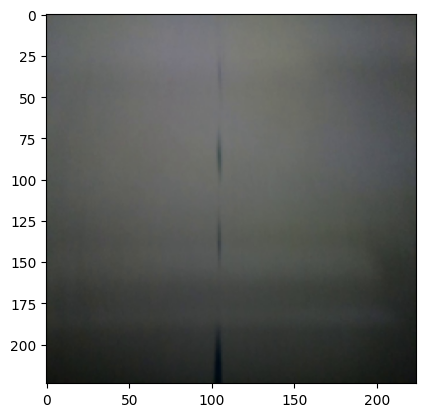

In [134]:
plt.imshow(seq_2_data[4].astype(int))

### Creating validation and test sets

Now we concatenate both the temporary set and the second and split the data into test and validation sets

In [72]:
df_val_test.label.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [59]:
# appending temporary val and test
df_val_test = pd.concat([df_tmp, df_seq_2], ignore_index=True)

# shuffling
df_val_test = df_val_test.sample(frac=1)

# splitting
df_val_2, df_test_2 = train_test_split(df_val_test, test_size = 0.5, shuffle=True, stratify=y)

In [60]:
# Create x_val, x_val_0 and y_val
mask_val_0 = df_val_2["label"] ==0
df_val_0 = df_val_2[mask_val_0]
x_val_0 = np.array(df_val_0.drop(["label"], axis =1).values)
x_val = np.array(df_val_2.drop(["label"], axis =1).values)
y_val = np.array(df_val_2["label"].values)

In [61]:
# Create x_test, y_test
x_test = np.array(df_test_2.drop(["label"], axis =1).values)
y_test = np.array(df_test_2["label"].values)

# Model

Now we build a simple fully connected autoencoder

In [67]:
# layers
img_in=Input(shape=(150528,))
layer1=Dense(128, activation="relu")(img_in)
layer2=Dense(64, activation="relu")(layer1)
layer3=Dense(32, activation="relu")(layer2)
layer4=Dense(64, activation="relu")(layer3)
layer5=Dense(128, activation="relu")(layer4)
img_out=Dense(150528, activation="sigmoid")(layer5)

In [68]:
myAE=Model(img_in, img_out)

In [69]:
# Define optimizer and loss function
myAE.compile(optimizer='adam' , loss='mean_squared_error')

In [70]:
myAE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150528)]          0         
                                                                 
 dense_6 (Dense)             (None, 128)               19267712  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 150528)            194181

Now we train the model

In [71]:
# input, output, epochs, batchsize, permutation, callback, 
history = myAE.fit(x=x_train, y=x_train,
            epochs=50,
            #batch_size=32, 
            #batch_size=64, 
            batch_size=256, 
            shuffle=True,
            validation_data = (x_val_0,x_val_0))

Epoch 1/50
29/29 [==============================] - 47s 1s/step - loss: 0.0089 - val_loss: 0.0013
Epoch 2/50
29/29 [==============================] - 38s 1s/step - loss: 9.2095e-04 - val_loss: 9.3144e-04
Epoch 3/50
29/29 [==============================] - 42s 1s/step - loss: 6.9559e-04 - val_loss: 6.7711e-04
Epoch 4/50
29/29 [==============================] - 36s 1s/step - loss: 5.5868e-04 - val_loss: 3.5425e-04
Epoch 5/50
29/29 [==============================] - 34s 1s/step - loss: 2.4782e-04 - val_loss: 1.8191e-04
Epoch 6/50
29/29 [==============================] - 36s 1s/step - loss: 1.1991e-04 - val_loss: 1.5305e-04
Epoch 7/50
29/29 [==============================] - 37s 1s/step - loss: 1.1335e-04 - val_loss: 1.2526e-04
Epoch 8/50
29/29 [==============================] - 35s 1s/step - loss: 1.0828e-04 - val_loss: 1.1479e-04
Epoch 9/50
29/29 [==============================] - 33s 1s/step - loss: 1.1046e-04 - val_loss: 1.1304e-04
Epoch 10/50
29/29 [==============================] - 3

We make a visualisation of loss :

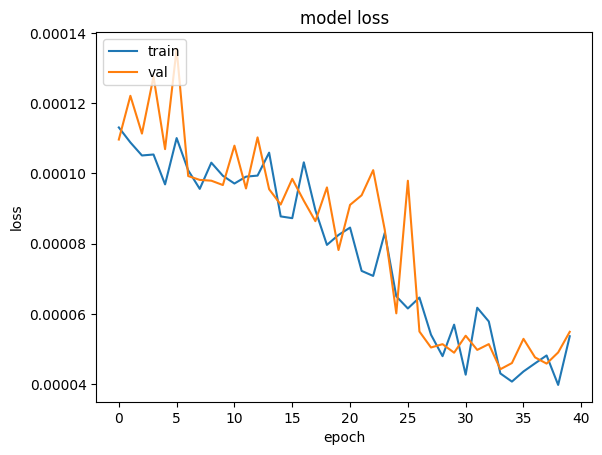

In [73]:
# history for loss
plt.plot(history.history['loss'][-40:])
plt.plot(history.history['val_loss'][-40:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

As expected the validation set loss is commonly higher than the train set loss

## Validation

As the validation has labels, we can test which threshold gives the most out of the trained anomalie detection algorithm.  
We first make a prediction of the validation set

In [74]:
x_val_hat=myAE.predict(x_val)

38/38 [==============================] - 2s 51ms/step


Then we compute the mean squared error between the original images and the recreated images

In [75]:
x_error=mse(x_val,x_val_hat)

In [76]:
DF_error=pd.DataFrame({"mse" : x_error, "label" : y_val})

Now we check the errors by label

<Axes: title={'center': 'mse'}, xlabel='label'>

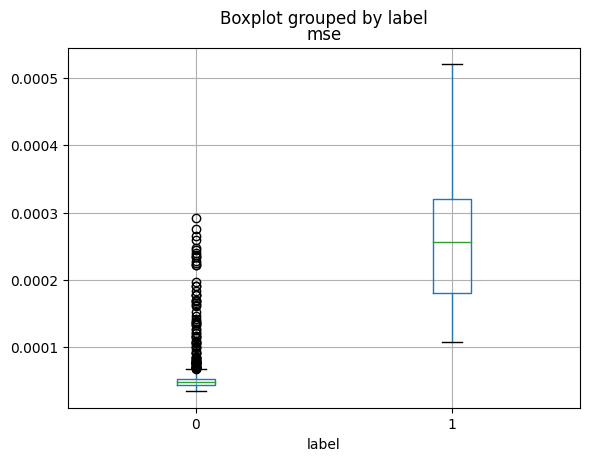

In [77]:
DF_error.boxplot(column = 'mse', by = 'label')

In [78]:
DF_error.groupby("label").describe()

mse                                                               
       count      mean       std       min       25%       50%       75%   
label                                                                      
0      962.0  0.000055  0.000031  0.000034  0.000043  0.000047  0.000053  \
1      224.0  0.000256  0.000089  0.000107  0.000180  0.000256  0.000321   

                 
            max  
label            
0      0.000292  
1      0.000521

There is an overlap between the error's interval in the case of **normal** and **anomaly**, but the anomaly errors are higher than 1e-4.

## Threshold of anomaly detection

Now that we have an idea of the maginitude of the errors, We will have to choose the best threshold for the error. This threshhold will be used to decide which image has an anomaly and which not.  
Therefore we will search for the best F1 score after varying the threshold.

In [87]:
res_list = []
for i in range(200):
    thr = i * 1e-5
    y_hat = (x_error > thr)
    pr1, rc1, fs1, supp1 = precision_recall_fscore_support(y_val, y_hat, zero_division=0.0)
    res_list.append([thr, pr1[1], rc1[1],fs1[1]])
final_list = pd.DataFrame(res_list, columns=["threshold", "precision", "recall", "F1score"])
final_list.head()

,threshold,precision,recall,F1score
0,0.00000,0.188870,1.0,0.317730
1,0.00001,0.188870,1.0,0.317730
2,0.00002,0.188870,1.0,0.317730
3,0.00003,0.188870,1.0,0.317730
4,0.00004,0.202166,1.0,0.336336


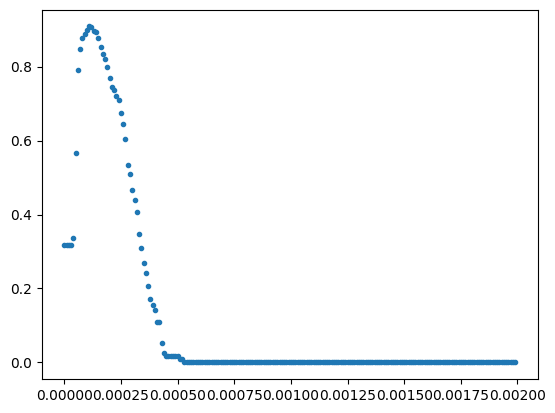

In [88]:
plt.plot(final_list["threshold"], final_list["F1score"], ".", label="F1score")

In [89]:
final_list.nlargest(5, "F1score")

,threshold,precision,recall,F1score
11,0.00011,0.835206,0.995536,0.908350
12,0.00012,0.845560,0.977679,0.906832
10,0.00010,0.817518,1.000000,0.899598
13,0.00013,0.854251,0.941964,0.895966
14,0.00014,0.872340,0.915179,0.893246


The highest F1 score happens at a threshold of 0.00011, therfore :

False alerts : 4.6  %
Dtection rate : 99.6  %


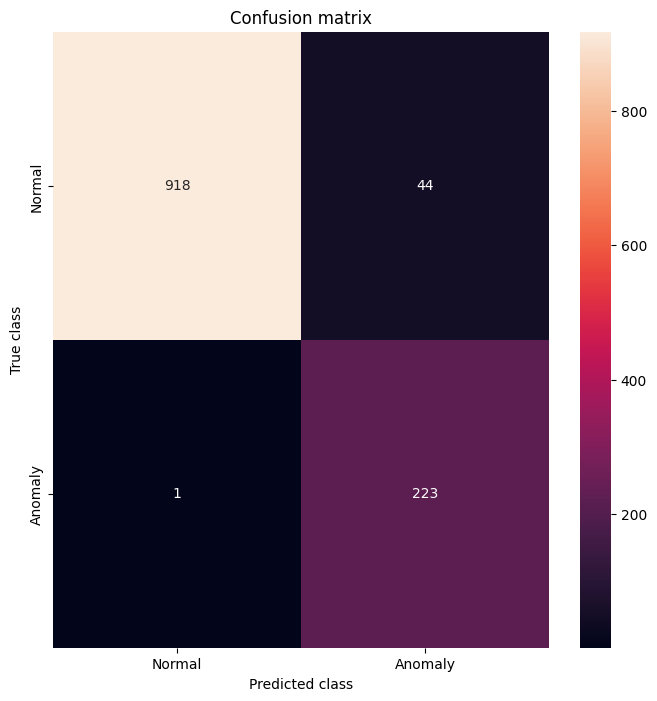

In [86]:
threshold_fixed = 0.00011
pred = (x_error > threshold_fixed)*1
LABELS = ["Normal","Anomaly"]
conf_matrix = confusion_matrix(DF_error.label, pred)

print("False alerts :" , round(conf_matrix[0][1] *100 / conf_matrix[0].sum(), 1)," %")
print("Dtection rate :" , round(conf_matrix[1][1] *100 / conf_matrix[1].sum(), 1)," %")

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The chosen threshold allows the algorithm to detect almost all anomalies, but have a slightly high False Positive rate.  
In our case we trained the algoritm on random images, but in practice the video feed is actually a sequence of images, therfore an anomalie will appear in several consecutive frames. we can reduce false positives, by testesting if an anomaly appears in several consecutive frames.

In [ ]:
# myAE.save("myAE.hdf5")

# Model evaluation

Now we evaluate our model on the test set, using the threshhold used earlier.

In [ ]:
# from keras.models import load_model
# myAE = load_model("myAE.hdf5")

In [90]:
x_test.shape

(1186, 150528)

### Predict all test sets

In [91]:
test_hat = myAE.predict(x_test)

38/38 [==============================] - 1s 32ms/step


In [93]:
err=mse(x_test, test_hat)

In [99]:
DF_test_error=pd.DataFrame({"mse" : err, "label" : y_test})

<Axes: title={'center': 'mse'}, xlabel='label'>

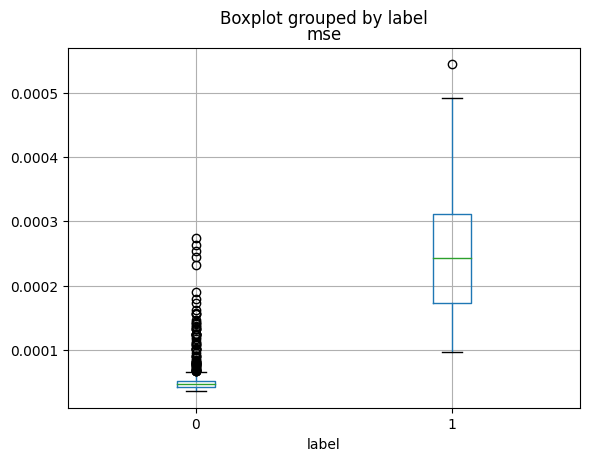

In [96]:
DF_test_error.boxplot(column = 'mse', by = 'label')

Same as earlier we look at the confusion matrix to see how the model is performing on the test set.

False positive rate : 3.3  %
Detection rate : 98.9  %


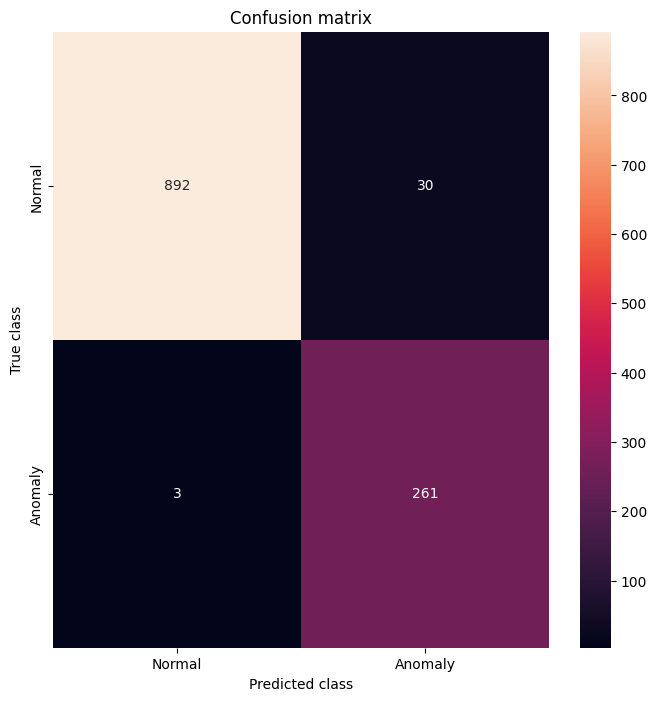

In [100]:
threshold_fixed = 0.00011
pred = (err > threshold_fixed)*1
LABELS = ["Normal","Anomaly"]
conf_matrix = confusion_matrix(DF_test_error.label, pred)

print("False positive rate :" , round(conf_matrix[0][1] *100 / conf_matrix[0].sum(), 1)," %")
print("Detection rate :" , round(conf_matrix[1][1] *100 / conf_matrix[1].sum(), 1)," %")

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The model performs exceptionally well on the test set.  
As explained earlier, in practice we reduce the false positives by by testesting if an anomaly appears in several consecutive frames.

# Visualizing Anomalies

This part aims to visualise and identify the position of the anomalies, therfore, we perform a prediction on an image presenting an anomaly, and visualize the heatmap of the errors.

In [101]:
label = DF_test_error["label"].values
pred = (err > threshold_fixed)*1
mask_tp = (label * pred) == 1

In [103]:
TP = x_test[mask_tp]
idx_img = 20
#idx_img = 5

# we need to expand the image shape in order to use it in the model
one_img=np.expand_dims(TP[idx_img], axis=0)

In [104]:
# Prediction
# one_img_hat=np.squeeze(myAE.predict(one_img), axis=0)
one_img_hat=myAE.predict(one_img)
one_img_hat.shape

1/1 [==============================] - 0s 52ms/step


(1, 150528)

In [105]:
pred_error=np.mean(np.power(one_img - one_img_hat,2))
print(pred_error)
threshold = 0.00008
has_defect = pred_error > threshold

0.00035107945


Now to understand what the autoencoder is doing, we put side by side the original image and the predicted image.

The pred error is : 0.00035107944859191775
Does image has a defect ?   : True


Text(0.5, 0, 'reconstructed')

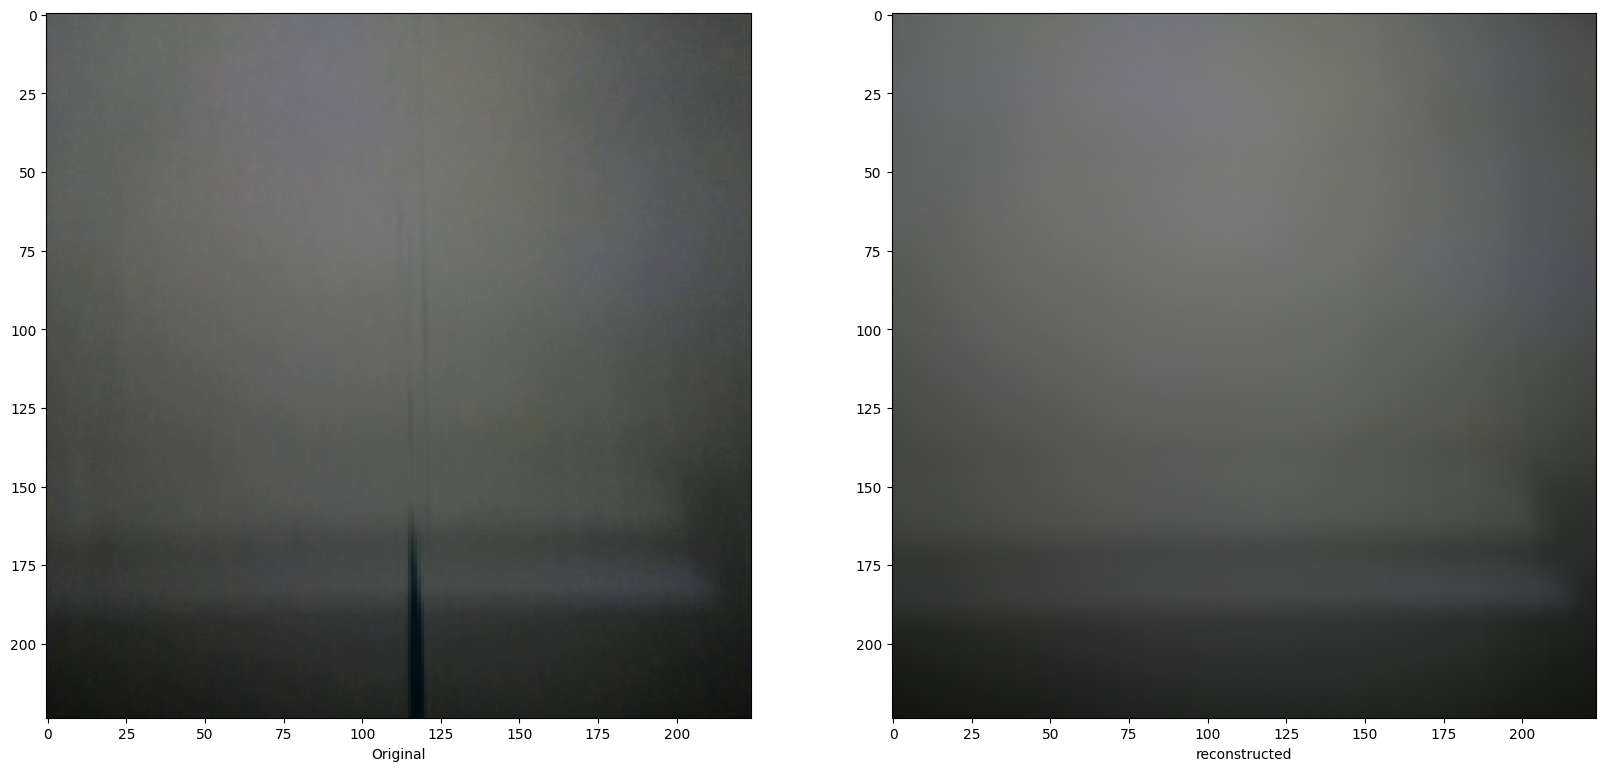

In [108]:
processed_img= TP[idx_img].reshape(224,224,3)
reconstructed_img=np.squeeze(one_img_hat, axis =0).reshape(224,224,3)

error=np.power(one_img_hat-one_img,2)
error_mask=error<=threshold
error[error_mask]=0
error_map=error.reshape(224,224,3)

# error_map = np.power(one_img_hat-one_img,2).reshape(224,224,3)

print(f"The pred error is : {pred_error}" )
print(f"Does image has a defect ?   : {has_defect}" )

fig = plt.figure(figsize=(20, 40))
fig.add_subplot(1, 2, 1)
plt.imshow(processed_img)
plt.xlabel('Original')
fig.add_subplot(1, 2, 2)
plt.imshow(reconstructed_img)
plt.xlabel('reconstructed')

We can see how the auto-encoder works. as the model is trained only on good data, the autoencoder, reproduces clean images despite the original photo is presenting an anomaly. By comparing the two images, we can determine if ther is an anomaly.  
Even better, we can localize the anomaly :

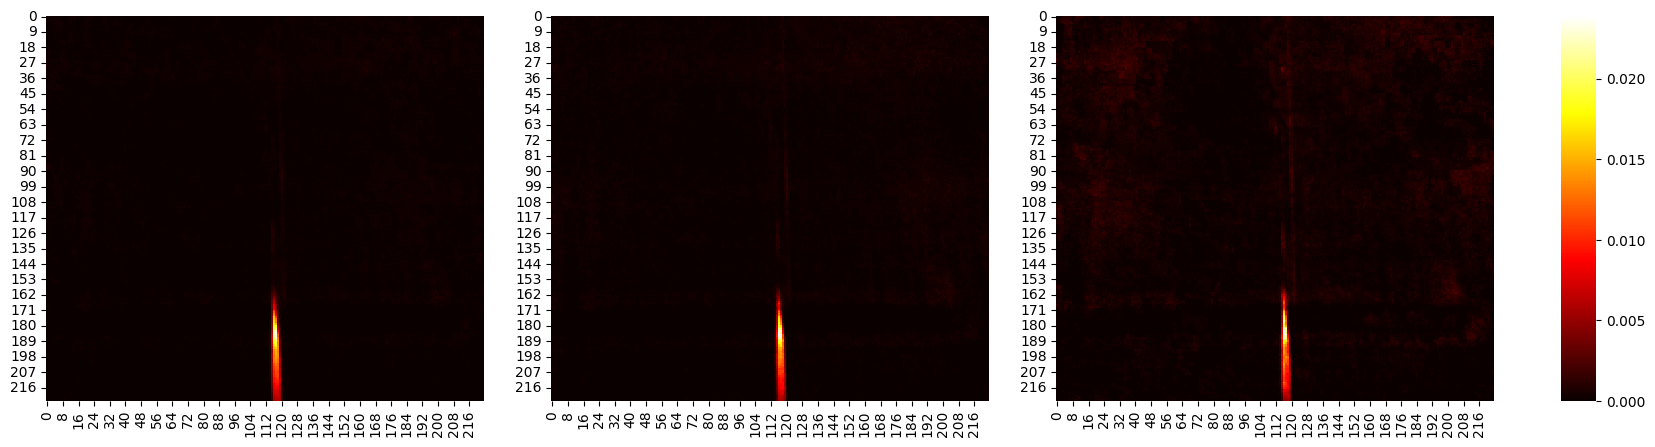

In [122]:
f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,1,1,0.08]}, figsize=(20,5))

g1 = sns.heatmap(error_map[:,:,0],cmap="hot",cbar=False,ax=ax1)
g2 = sns.heatmap(error_map[:,:,1],cmap="hot",cbar=False,ax=ax2)
g3 = sns.heatmap(error_map[:,:,2],cmap="hot",ax=ax3, cbar_ax=axcb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


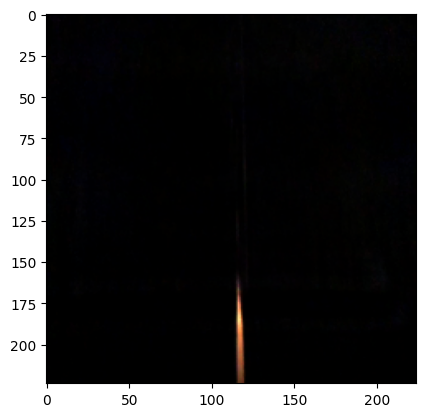

In [143]:
plt.imshow((error_map*6000).astype(int))